In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy as sp

from functools import partial
from datetime import date

import theano.tensor as tt
from theano import shared
from theano.tensor import slinalg
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture
from pymc3 import DensityDist, CategoricalGibbsMetropolis
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import advi, adam, fit
from pymc3 import traceplot, forestplot

In [3]:
DATA_DIR = '../data/clean/'

Import dataset of first-year truncated patients and extract minimum 5 observations

In [4]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'bmi_by_patient.csv', index_col=0)
                      .dropna(axis=1, thresh=5))
bmi_by_patient.head()

1621101  1685338    1713205   1958537    2025534    2062537  \
Days                                                                  
0     27.464844      NaN  29.679341  27.51063  27.032689  27.484552   
1           NaN      NaN        NaN       NaN        NaN        NaN   
2           NaN      NaN        NaN       NaN        NaN        NaN   
3           NaN      NaN        NaN       NaN        NaN        NaN   
4           NaN      NaN        NaN       NaN        NaN        NaN   

        2087799    2129427    2186450    2382232    ...       40985475  \
Days                                                ...                  
0     29.380994  27.614212  29.743767  28.201669    ...      27.777479   
1           NaN        NaN        NaN        NaN    ...            NaN   
2           NaN        NaN        NaN        NaN    ...            NaN   
3           NaN        NaN        NaN        NaN    ...            NaN   
4           NaN        NaN        NaN        NaN    ...            NaN   

       41005570   41014622  41014655   41043167   41052325  41054388  \
Days                                                                   
0     29.785761  28.921647       NaN  28.096818  28.663549  27.26058   
1     29.785761        NaN       NaN        NaN        NaN       NaN   
2     29.969401        NaN       NaN        NaN        NaN       NaN   
3           NaN  29.030746       NaN        NaN        NaN       NaN   
4           NaN        NaN       NaN        NaN        NaN       NaN   

       41077231   41087032   41248451  
Days                                   
0     27.125971  27.423469  28.801188  
1           NaN        NaN  28.695456  
2           NaN        NaN  29.209745  
3           NaN        NaN  28.695456  
4           NaN        NaN        NaN  

[5 rows x 5915 columns]

In [5]:
assert bmi_by_patient.notnull().sum().min() == 5

In [6]:
#bmi_by_patient.index = pd.Series(bmi_by_patient.index).apply(partial(pd.Timedelta, unit='D'))
bmi_by_patient.index =  pd.to_datetime(bmi_by_patient.index, unit='D')

In [7]:
bmi_resampled = bmi_by_patient.resample('2W').mean()
bmi_resampled.shape

(27, 5915)

In [8]:
data_subset = bmi_resampled.iloc[:, :500]

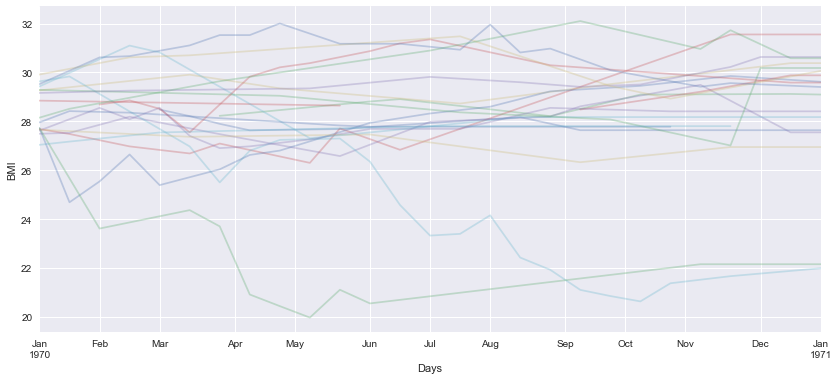

In [9]:
fig, axes = plt.subplots(figsize=(14,6))
(bmi_resampled[np.random.choice(bmi_resampled.columns, 20)].interpolate(limit=10)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

Stick-breaking function for Dirichlet process

In [10]:
def stick_breaking(beta, complete=False):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    p = beta * portion_remaining
    if not complete:
        return p
    return tt.concatenate([p, [1-p.sum()]])

Maximum number of groups

In [11]:
K = 20
D, N = data_subset.shape

In [12]:
nknots = 10
knots = np.linspace(0, data_subset.shape[0]-1, nknots)

basis_funcs = sp.interpolate.BSpline(knots, np.eye(nknots), k=3)

In [13]:
from pymc3 import Minibatch

In [18]:
with Model() as model:
    
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=K)
    ω = Deterministic('ω', stick_breaking(β))
    
    z = Categorical('z', ω, shape=N)
    
    σ = HalfCauchy('σ', 5, shape=K)

    θ = tt.stack([GaussianRandomWalk('θ_%i' % i, sd=σ[i], shape=nknots) for i in range(K)])

    sd = HalfCauchy('sd', 5)
    
    for i in range(N):
        
        data = data_subset.iloc[:, i]
        observed = ~np.isnan(data)
        y = data[observed].values
        x = np.where(observed)[0].reshape(-1,1)
        n = y.shape[0]
        
        Bx = shared(basis_funcs(x))
        
        Normal('trajectory_%i' % i, tt.flatten(Bx.dot(θ[z[i]])), sd=sd, observed=y)
#         Normal('trajectory_%i' % i, tt.stack(interpolate(knots, θ[z[i]], x)), sd=sd, observed=y)

TypeError: TensorType does not support iteration. Maybe you are using builtin.sum instead of theano.tensor.sum? (Maybe .max?)

In [23]:
niterations = 10000
nkeep = 1000

In [24]:
with model:
    
    approx = fit(n=10000)

ValueError: Model should not include discrete RVs

In [25]:
with model:
    trace = sample(niterations, init=None, tune=niterations-nkeep, random_seed=20090425)

Assigned NUTS to α_log__
Assigned NUTS to β_logodds__
Assigned CategoricalGibbsMetropolis to z
Assigned NUTS to σ_log__
Assigned NUTS to θ_0
Assigned NUTS to θ_1
Assigned NUTS to θ_2
Assigned NUTS to θ_3
Assigned NUTS to θ_4
Assigned NUTS to θ_5
Assigned NUTS to θ_6
Assigned NUTS to θ_7
Assigned NUTS to θ_8
Assigned NUTS to θ_9
Assigned NUTS to θ_10
Assigned NUTS to θ_11
Assigned NUTS to θ_12
Assigned NUTS to θ_13
Assigned NUTS to θ_14
Assigned NUTS to θ_15
Assigned NUTS to θ_16
Assigned NUTS to θ_17
Assigned NUTS to θ_18
Assigned NUTS to θ_19
Assigned NUTS to sd_log__


00001	#include <Python.h>
00002	#include <iostream>
00003	#include "theano_mod_helper.h"
00004	#include <math.h>
00005	#include <numpy/arrayobject.h>
00006	#include <numpy/arrayscalars.h>
00007	#include <vector>
00008	#include <algorithm>
00009	//////////////////////
00010	////  Support Code
00011	//////////////////////
00012	
00013	    namespace {
00014	    struct __struct_compiled_op_m0275634a3cafc0d8f5c8589c24375f54 {
00015	        PyObject* __ERROR;
00016	
00017	        PyObject* storage_V3;
00018	PyObject* storage_V5;
00019	PyObject* storage_V7;
00020	PyObject* storage_V9;
00021	PyObject* storage_V11;
00022	PyObject* storage_V13;
00023	PyObject* storage_V15;
00024	PyObject* storage_V17;
00025	PyObject* storage_V19;
00026	PyObject* storage_V21;
00027	PyObject* storage_V23;
00028	PyObject* storage_V25;
00029	PyObject* storage_V27;
00030	PyObject* storage_V29;
00031	PyObject* storage_V31;
00032	PyObject* storage_V33;
00033	PyObject* storage_V35;
00034	PyObject* storage_V37;
00035	PyO

00439	PyObject* storage_V847;
00440	PyObject* storage_V849;
00441	PyObject* storage_V851;
00442	PyObject* storage_V853;
00443	PyObject* storage_V855;
00444	PyObject* storage_V857;
00445	PyObject* storage_V859;
00446	PyObject* storage_V861;
00447	PyObject* storage_V863;
00448	PyObject* storage_V865;
00449	PyObject* storage_V867;
00450	PyObject* storage_V869;
00451	PyObject* storage_V871;
00452	PyObject* storage_V873;
00453	PyObject* storage_V875;
00454	PyObject* storage_V877;
00455	PyObject* storage_V879;
00456	PyObject* storage_V881;
00457	PyObject* storage_V883;
00458	PyObject* storage_V885;
00459	PyObject* storage_V887;
00460	PyObject* storage_V889;
00461	PyObject* storage_V891;
00462	PyObject* storage_V893;
00463	PyObject* storage_V895;
00464	PyObject* storage_V897;
00465	PyObject* storage_V899;
00466	PyObject* storage_V901;
00467	PyObject* storage_V903;
00468	PyObject* storage_V905;
00469	PyObject* storage_V907;
00470	PyObject* storage_V909;
00471	PyObject* storage_V911;
00472	PyOb

01821	
01822	
01823	
01824	
01825	
01826	
01827	
01828	
01829	
01830	
01831	
01832	
01833	
01834	
01835	
01836	
01837	
01838	
01839	
01840	
01841	
01842	
01843	
01844	
01845	
01846	
01847	
01848	
01849	
01850	
01851	
01852	
01853	
01854	
01855	
01856	
01857	
01858	
01859	
01860	
01861	
01862	
01863	
01864	
01865	
01866	
01867	
01868	
01869	
01870	
01871	
01872	
01873	
01874	
01875	
01876	
01877	
01878	
01879	
01880	
01881	
01882	
01883	
01884	
01885	
01886	
01887	
01888	
01889	
01890	
01891	
01892	
01893	
01894	
01895	
01896	
01897	
01898	
01899	
01900	
01901	
01902	
01903	
01904	
01905	
01906	
01907	
01908	
01909	
01910	
01911	
01912	
01913	
01914	
01915	
01916	
01917	
01918	
01919	
01920	
01921	
01922	
01923	
01924	
01925	
01926	
01927	
01928	
01929	
01930	
01931	
01932	
01933	
01934	
01935	
01936	
01937	
01938	
01939	
01940	
01941	
01942	
01943	
01944	
01945	
01946	
01947	
01948	
01949	
01950	
01951	
01952	
01953	
01954	
01955	
01956	
01957	
01958	
01959	
01960	
01961	
01962	
01963	

02943	double __DUMMY_531;
02944	__label_533:
02945	
02946	double __DUMMY_533;
02947	__label_535:
02948	
02949	double __DUMMY_535;
02950	__label_537:
02951	
02952	double __DUMMY_537;
02953	__label_539:
02954	
02955	double __DUMMY_539;
02956	__label_541:
02957	
02958	double __DUMMY_541;
02959	__label_543:
02960	
02961	double __DUMMY_543;
02962	__label_545:
02963	
02964	double __DUMMY_545;
02965	__label_547:
02966	
02967	double __DUMMY_547;
02968	__label_549:
02969	
02970	double __DUMMY_549;
02971	__label_551:
02972	
02973	double __DUMMY_551;
02974	__label_553:
02975	
02976	double __DUMMY_553;
02977	__label_555:
02978	
02979	double __DUMMY_555;
02980	__label_557:
02981	
02982	double __DUMMY_557;
02983	__label_559:
02984	
02985	double __DUMMY_559;
02986	__label_561:
02987	
02988	double __DUMMY_561;
02989	__label_563:
02990	
02991	double __DUMMY_563;
02992	__label_565:
02993	
02994	double __DUMMY_565;
02995	__label_567:
02996	
02997	double __DUMMY_567;
02998	__label_569:
02999	
03000	double

04145	Py_XDECREF(this->storage_V837);
04146	Py_XDECREF(this->storage_V839);
04147	Py_XDECREF(this->storage_V841);
04148	Py_XDECREF(this->storage_V843);
04149	Py_XDECREF(this->storage_V845);
04150	Py_XDECREF(this->storage_V847);
04151	Py_XDECREF(this->storage_V849);
04152	Py_XDECREF(this->storage_V851);
04153	Py_XDECREF(this->storage_V853);
04154	Py_XDECREF(this->storage_V855);
04155	Py_XDECREF(this->storage_V857);
04156	Py_XDECREF(this->storage_V859);
04157	Py_XDECREF(this->storage_V861);
04158	Py_XDECREF(this->storage_V863);
04159	Py_XDECREF(this->storage_V865);
04160	Py_XDECREF(this->storage_V867);
04161	Py_XDECREF(this->storage_V869);
04162	Py_XDECREF(this->storage_V871);
04163	Py_XDECREF(this->storage_V873);
04164	Py_XDECREF(this->storage_V875);
04165	Py_XDECREF(this->storage_V877);
04166	Py_XDECREF(this->storage_V879);
04167	Py_XDECREF(this->storage_V881);
04168	Py_XDECREF(this->storage_V883);
04169	Py_XDECREF(this->storage_V885);
04170	Py_XDECREF(this->storage_V887);
04171	Py_XDE

05469	            
05470	    PyObject* py_V405;
05471	    
05472	        PyArrayObject* V405;
05473	        
05474	            typedef npy_float64 dtype_V405;
05475	            
05476	    PyObject* py_V407;
05477	    
05478	        PyArrayObject* V407;
05479	        
05480	            typedef npy_float64 dtype_V407;
05481	            
05482	    PyObject* py_V409;
05483	    
05484	        PyArrayObject* V409;
05485	        
05486	            typedef npy_float64 dtype_V409;
05487	            
05488	    PyObject* py_V411;
05489	    
05490	        PyArrayObject* V411;
05491	        
05492	            typedef npy_float64 dtype_V411;
05493	            
05494	    PyObject* py_V413;
05495	    
05496	        PyArrayObject* V413;
05497	        
05498	            typedef npy_float64 dtype_V413;
05499	            
05500	    PyObject* py_V415;
05501	    
05502	        PyArrayObject* V415;
05503	        
05504	            typedef npy_float64 dtype_V415;
05505	            
05506	    PyObject* py_V417

06978	        PyArrayObject* V907;
06979	        
06980	            typedef npy_float64 dtype_V907;
06981	            
06982	    PyObject* py_V909;
06983	    
06984	        PyArrayObject* V909;
06985	        
06986	            typedef npy_float64 dtype_V909;
06987	            
06988	    PyObject* py_V911;
06989	    
06990	        PyArrayObject* V911;
06991	        
06992	            typedef npy_float64 dtype_V911;
06993	            
06994	    PyObject* py_V913;
06995	    
06996	        PyArrayObject* V913;
06997	        
06998	            typedef npy_float64 dtype_V913;
06999	            
07000	    PyObject* py_V915;
07001	    
07002	        PyArrayObject* V915;
07003	        
07004	            typedef npy_float64 dtype_V915;
07005	            
07006	    PyObject* py_V917;
07007	    
07008	        PyArrayObject* V917;
07009	        
07010	            typedef npy_float64 dtype_V917;
07011	            
07012	    PyObject* py_V919;
07013	    
07014	        PyArrayObject* V919;
07015	     

08455	                {
08456	        __failure = 26;
08457	        if (!PyErr_Occurred()) {
08458	            PyErr_SetString(PyExc_RuntimeError,
08459	                "Unexpected error in an Op's C code. "
08460	                "No Python exception was set.");
08461	            }
08462	        goto __label_26;}
08463	            }
08464	            // We expect NPY_FLOAT64
08465	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V25)) {
08466	                PyArrayObject * tmp = (PyArrayObject*) py_V25;
08467	                PyErr_Format(PyExc_NotImplementedError,
08468	                             "expected an aligned array of type %ld "
08469	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
08470	                             " with %ld dimensions, with 3 last dims "
08471	                             "%ld, %ld, %ld"
08472	                             " and 3 last strides %ld %ld, %ld.",
08473	                             (long int) NPY_FLOAT64,
0

09986	                             (long int) PyArray_TYPE((PyArrayObject*) py_V61),
09987	                             (long int) PyArray_NDIM(tmp),
09988	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
09989	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] : -1),
09990	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
09991	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-2] : -1),
09992	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
09993	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-1] : -1),
09994	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
09995	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
09996	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
09997	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
09998	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
09999	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
10000	            );
10001

11498	                             (long int) PyArray_TYPE((PyArrayObject*) py_V97),
11499	                             (long int) PyArray_NDIM(tmp),
11500	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
11501	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] : -1),
11502	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
11503	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-2] : -1),
11504	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
11505	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-1] : -1),
11506	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
11507	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
11508	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
11509	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
11510	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
11511	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
11512	            );
11513

12781	            }
12782	            // This is a TypeError to be consistent with DEBUG_MODE
12783	            // Note: DEBUG_MODE also tells the name of the container
12784	            if (PyArray_TYPE((PyArrayObject*) py_V127) != NPY_FLOAT64) {
12785	                PyErr_Format(PyExc_TypeError,
12786	                             "expected type_num %d (NPY_FLOAT64) got %d",
12787	                             NPY_FLOAT64, PyArray_TYPE((PyArrayObject*) py_V127));
12788	                {
12789	        __failure = 128;
12790	        if (!PyErr_Occurred()) {
12791	            PyErr_SetString(PyExc_RuntimeError,
12792	                "Unexpected error in an Op's C code. "
12793	                "No Python exception was set.");
12794	            }
12795	        goto __label_128;}
12796	            }
12797	            
12798	        V127 = (PyArrayObject*)(py_V127);
12799	        Py_XINCREF(V127);
12800	        
12801	{
12802	
12803	    py_V129 = PyList_GET_ITEM(storage_V129, 0);
12804	    {

14006	        goto __label_158;}
14007	            }
14008	            // We expect NPY_FLOAT64
14009	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V157)) {
14010	                PyArrayObject * tmp = (PyArrayObject*) py_V157;
14011	                PyErr_Format(PyExc_NotImplementedError,
14012	                             "expected an aligned array of type %ld "
14013	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
14014	                             " with %ld dimensions, with 3 last dims "
14015	                             "%ld, %ld, %ld"
14016	                             " and 3 last strides %ld %ld, %ld.",
14017	                             (long int) NPY_FLOAT64,
14018	                             (long int) PyArray_TYPE((PyArrayObject*) py_V157),
14019	                             (long int) PyArray_NDIM(tmp),
14020	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
14021	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] :

15431	                "Unexpected error in an Op's C code. "
15432	                "No Python exception was set.");
15433	            }
15434	        goto __label_192;}
15435	            }
15436	            // We expect NPY_FLOAT64
15437	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V191)) {
15438	                PyArrayObject * tmp = (PyArrayObject*) py_V191;
15439	                PyErr_Format(PyExc_NotImplementedError,
15440	                             "expected an aligned array of type %ld "
15441	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
15442	                             " with %ld dimensions, with 3 last dims "
15443	                             "%ld, %ld, %ld"
15444	                             " and 3 last strides %ld %ld, %ld.",
15445	                             (long int) NPY_FLOAT64,
15446	                             (long int) PyArray_TYPE((PyArrayObject*) py_V191),
15447	                             (long int) PyArray_NDIM(

17026	            PyErr_SetString(PyExc_RuntimeError,
17027	                "Unexpected error in an Op's C code. "
17028	                "No Python exception was set.");
17029	            }
17030	        goto __label_230;}
17031	            }
17032	            // We expect NPY_FLOAT64
17033	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V229)) {
17034	                PyArrayObject * tmp = (PyArrayObject*) py_V229;
17035	                PyErr_Format(PyExc_NotImplementedError,
17036	                             "expected an aligned array of type %ld "
17037	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
17038	                             " with %ld dimensions, with 3 last dims "
17039	                             "%ld, %ld, %ld"
17040	                             " and 3 last strides %ld %ld, %ld.",
17041	                             (long int) NPY_FLOAT64,
17042	                             (long int) PyArray_TYPE((PyArrayObject*) py_V229),
17043

18556	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
18557	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] : -1),
18558	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
18559	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-2] : -1),
18560	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
18561	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-1] : -1),
18562	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
18563	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
18564	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
18565	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
18566	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
18567	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
18568	            );
18569	                {
18570	        __failure = 266;
18571	        if (!PyErr_Occurred()) {
18572	            PyErr_SetString(PyExc_RuntimeError,
18573	 

19985	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] : -1),
19986	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
19987	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-2] : -1),
19988	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
19989	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-1] : -1),
19990	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
19991	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
19992	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
19993	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
19994	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
19995	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
19996	            );
19997	                {
19998	        __failure = 300;
19999	        if (!PyErr_Occurred()) {
20000	            PyErr_SetString(PyExc_RuntimeError,
20001	                "Unexpected error in an Op's C code. "
20002	            

21535	        Py_XINCREF(V335);
21536	        
21537	{
21538	
21539	    py_V337 = PyList_GET_ITEM(storage_V337, 0);
21540	    {Py_XINCREF(py_V337);}
21541	    
21542	            V337 = NULL;
21543	            if (py_V337 == Py_None) {
21544	                // We can either fail here or set V337 to NULL and rely on Ops
21545	                // using tensors to handle the NULL case, but if they fail to do so
21546	                // they'll end up with nasty segfaults, so this is public service.
21547	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
21548	                {
21549	        __failure = 338;
21550	        if (!PyErr_Occurred()) {
21551	            PyErr_SetString(PyExc_RuntimeError,
21552	                "Unexpected error in an Op's C code. "
21553	                "No Python exception was set.");
21554	            }
21555	        goto __label_338;}
21556	            }
21557	            if (!PyArray_Check(py_V337)) {
21558	                PyE

23018	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
23019	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
23020	            );
23021	                {
23022	        __failure = 372;
23023	        if (!PyErr_Occurred()) {
23024	            PyErr_SetString(PyExc_RuntimeError,
23025	                "Unexpected error in an Op's C code. "
23026	                "No Python exception was set.");
23027	            }
23028	        goto __label_372;}
23029	            }
23030	            // This is a TypeError to be consistent with DEBUG_MODE
23031	            // Note: DEBUG_MODE also tells the name of the container
23032	            if (PyArray_TYPE((PyArrayObject*) py_V371) != NPY_FLOAT64) {
23033	                PyErr_Format(PyExc_TypeError,
23034	                             "expected type_num %d (NPY_FLOAT64) got %d",
23035	                             NPY_FLOAT64, PyArray_TYPE((PyArrayObject*) py_V371));
23036	                {
23037	        __failure = 372;


24540	        goto __label_408;}
24541	            }
24542	            // This is a TypeError to be consistent with DEBUG_MODE
24543	            // Note: DEBUG_MODE also tells the name of the container
24544	            if (PyArray_TYPE((PyArrayObject*) py_V407) != NPY_FLOAT64) {
24545	                PyErr_Format(PyExc_TypeError,
24546	                             "expected type_num %d (NPY_FLOAT64) got %d",
24547	                             NPY_FLOAT64, PyArray_TYPE((PyArrayObject*) py_V407));
24548	                {
24549	        __failure = 408;
24550	        if (!PyErr_Occurred()) {
24551	            PyErr_SetString(PyExc_RuntimeError,
24552	                "Unexpected error in an Op's C code. "
24553	                "No Python exception was set.");
24554	            }
24555	        goto __label_408;}
24556	            }
24557	            
24558	        V407 = (PyArrayObject*)(py_V407);
24559	        Py_XINCREF(V407);
24560	        
24561	{
24562	
24563	    py_V409 = PyList_GET_I

26039	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
26040	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
26041	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
26042	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
26043	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
26044	            );
26045	                {
26046	        __failure = 444;
26047	        if (!PyErr_Occurred()) {
26048	            PyErr_SetString(PyExc_RuntimeError,
26049	                "Unexpected error in an Op's C code. "
26050	                "No Python exception was set.");
26051	            }
26052	        goto __label_444;}
26053	            }
26054	            // This is a TypeError to be consistent with DEBUG_MODE
26055	            // Note: DEBUG_MODE also tells the name of the container
26056	            if (PyArray_TYPE((PyArrayObject*) py_V443) != NPY_FLOAT64) {
26057	                PyErr_Format(PyExc_TypeError,
26058	            

27528	                "No Python exception was set.");
27529	            }
27530	        goto __label_480;}
27531	            }
27532	            // We expect NPY_FLOAT64
27533	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V479)) {
27534	                PyArrayObject * tmp = (PyArrayObject*) py_V479;
27535	                PyErr_Format(PyExc_NotImplementedError,
27536	                             "expected an aligned array of type %ld "
27537	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
27538	                             " with %ld dimensions, with 3 last dims "
27539	                             "%ld, %ld, %ld"
27540	                             " and 3 last strides %ld %ld, %ld.",
27541	                             (long int) NPY_FLOAT64,
27542	                             (long int) PyArray_TYPE((PyArrayObject*) py_V479),
27543	                             (long int) PyArray_NDIM(tmp),
27544	                             (long int) (PyArray_

29040	                "No Python exception was set.");
29041	            }
29042	        goto __label_516;}
29043	            }
29044	            // We expect NPY_FLOAT64
29045	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V515)) {
29046	                PyArrayObject * tmp = (PyArrayObject*) py_V515;
29047	                PyErr_Format(PyExc_NotImplementedError,
29048	                             "expected an aligned array of type %ld "
29049	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
29050	                             " with %ld dimensions, with 3 last dims "
29051	                             "%ld, %ld, %ld"
29052	                             " and 3 last strides %ld %ld, %ld.",
29053	                             (long int) NPY_FLOAT64,
29054	                             (long int) PyArray_TYPE((PyArrayObject*) py_V515),
29055	                             (long int) PyArray_NDIM(tmp),
29056	                             (long int) (PyArray_

30532	                // We can either fail here or set V551 to NULL and rely on Ops
30533	                // using tensors to handle the NULL case, but if they fail to do so
30534	                // they'll end up with nasty segfaults, so this is public service.
30535	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
30536	                {
30537	        __failure = 552;
30538	        if (!PyErr_Occurred()) {
30539	            PyErr_SetString(PyExc_RuntimeError,
30540	                "Unexpected error in an Op's C code. "
30541	                "No Python exception was set.");
30542	            }
30543	        goto __label_552;}
30544	            }
30545	            if (!PyArray_Check(py_V551)) {
30546	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
30547	                {
30548	        __failure = 552;
30549	        if (!PyErr_Occurred()) {
30550	            PyErr_SetString(PyExc_RuntimeError,
30551	                "Unexpecte

32028	                "Unexpected error in an Op's C code. "
32029	                "No Python exception was set.");
32030	            }
32031	        goto __label_586;}
32032	            }
32033	            
32034	        V585 = (PyArrayObject*)(py_V585);
32035	        Py_XINCREF(V585);
32036	        
32037	{
32038	
32039	    py_V587 = PyList_GET_ITEM(storage_V587, 0);
32040	    {Py_XINCREF(py_V587);}
32041	    
32042	            V587 = NULL;
32043	            if (py_V587 == Py_None) {
32044	                // We can either fail here or set V587 to NULL and rely on Ops
32045	                // using tensors to handle the NULL case, but if they fail to do so
32046	                // they'll end up with nasty segfaults, so this is public service.
32047	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
32048	                {
32049	        __failure = 588;
32050	        if (!PyErr_Occurred()) {
32051	            PyErr_SetString(PyExc_RuntimeError,
32052	 

33522	        __failure = 622;
33523	        if (!PyErr_Occurred()) {
33524	            PyErr_SetString(PyExc_RuntimeError,
33525	                "Unexpected error in an Op's C code. "
33526	                "No Python exception was set.");
33527	            }
33528	        goto __label_622;}
33529	            }
33530	            // This is a TypeError to be consistent with DEBUG_MODE
33531	            // Note: DEBUG_MODE also tells the name of the container
33532	            if (PyArray_TYPE((PyArrayObject*) py_V621) != NPY_FLOAT64) {
33533	                PyErr_Format(PyExc_TypeError,
33534	                             "expected type_num %d (NPY_FLOAT64) got %d",
33535	                             NPY_FLOAT64, PyArray_TYPE((PyArrayObject*) py_V621));
33536	                {
33537	        __failure = 622;
33538	        if (!PyErr_Occurred()) {
33539	            PyErr_SetString(PyExc_RuntimeError,
33540	                "Unexpected error in an Op's C code. "
33541	                "No Pyt

34914	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
34915	                {
34916	        __failure = 656;
34917	        if (!PyErr_Occurred()) {
34918	            PyErr_SetString(PyExc_RuntimeError,
34919	                "Unexpected error in an Op's C code. "
34920	                "No Python exception was set.");
34921	            }
34922	        goto __label_656;}
34923	            }
34924	            // We expect NPY_FLOAT64
34925	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V655)) {
34926	                PyArrayObject * tmp = (PyArrayObject*) py_V655;
34927	                PyErr_Format(PyExc_NotImplementedError,
34928	                             "expected an aligned array of type %ld "
34929	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
34930	                             " with %ld dimensions, with 3 last dims "
34931	                             "%ld, %ld, %ld"
34932	                             " and 3 last 

36454	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
36455	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
36456	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
36457	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
36458	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
36459	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
36460	            );
36461	                {
36462	        __failure = 692;
36463	        if (!PyErr_Occurred()) {
36464	            PyErr_SetString(PyExc_RuntimeError,
36465	                "Unexpected error in an Op's C code. "
36466	                "No Python exception was set.");
36467	            }
36468	        goto __label_692;}
36469	            }
36470	            // This is a TypeError to be consistent with DEBUG_MODE
36471	            // Note: DEBUG_MODE also tells the name of the container
36472	            if (PyArray_TYPE((PyArrayObject*) py_V691) != NPY_FLOAT64) 

37919	    py_V727 = PyList_GET_ITEM(storage_V727, 0);
37920	    {Py_XINCREF(py_V727);}
37921	    
37922	            V727 = NULL;
37923	            if (py_V727 == Py_None) {
37924	                // We can either fail here or set V727 to NULL and rely on Ops
37925	                // using tensors to handle the NULL case, but if they fail to do so
37926	                // they'll end up with nasty segfaults, so this is public service.
37927	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
37928	                {
37929	        __failure = 728;
37930	        if (!PyErr_Occurred()) {
37931	            PyErr_SetString(PyExc_RuntimeError,
37932	                "Unexpected error in an Op's C code. "
37933	                "No Python exception was set.");
37934	            }
37935	        goto __label_728;}
37936	            }
37937	            if (!PyArray_Check(py_V727)) {
37938	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
37939	 

39458	        goto __label_764;}
39459	            }
39460	            // We expect NPY_FLOAT64
39461	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V763)) {
39462	                PyArrayObject * tmp = (PyArrayObject*) py_V763;
39463	                PyErr_Format(PyExc_NotImplementedError,
39464	                             "expected an aligned array of type %ld "
39465	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
39466	                             " with %ld dimensions, with 3 last dims "
39467	                             "%ld, %ld, %ld"
39468	                             " and 3 last strides %ld %ld, %ld.",
39469	                             (long int) NPY_FLOAT64,
39470	                             (long int) PyArray_TYPE((PyArrayObject*) py_V763),
39471	                             (long int) PyArray_NDIM(tmp),
39472	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
39473	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] :

40952	                {
40953	        __failure = 800;
40954	        if (!PyErr_Occurred()) {
40955	            PyErr_SetString(PyExc_RuntimeError,
40956	                "Unexpected error in an Op's C code. "
40957	                "No Python exception was set.");
40958	            }
40959	        goto __label_800;}
40960	            }
40961	            if (!PyArray_Check(py_V799)) {
40962	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
40963	                {
40964	        __failure = 800;
40965	        if (!PyErr_Occurred()) {
40966	            PyErr_SetString(PyExc_RuntimeError,
40967	                "Unexpected error in an Op's C code. "
40968	                "No Python exception was set.");
40969	            }
40970	        goto __label_800;}
40971	            }
40972	            // We expect NPY_FLOAT64
40973	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V799)) {
40974	                PyArrayObject * tmp = (PyArrayObject*) py_V799;
40975	        

42447	        goto __label_834;}
42448	            }
42449	            
42450	        V833 = (PyArrayObject*)(py_V833);
42451	        Py_XINCREF(V833);
42452	        
42453	{
42454	
42455	    py_V835 = PyList_GET_ITEM(storage_V835, 0);
42456	    {Py_XINCREF(py_V835);}
42457	    
42458	            V835 = NULL;
42459	            if (py_V835 == Py_None) {
42460	                // We can either fail here or set V835 to NULL and rely on Ops
42461	                // using tensors to handle the NULL case, but if they fail to do so
42462	                // they'll end up with nasty segfaults, so this is public service.
42463	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
42464	                {
42465	        __failure = 836;
42466	        if (!PyErr_Occurred()) {
42467	            PyErr_SetString(PyExc_RuntimeError,
42468	                "Unexpected error in an Op's C code. "
42469	                "No Python exception was set.");
42470	            }
42471	 

43976	                {
43977	        __failure = 872;
43978	        if (!PyErr_Occurred()) {
43979	            PyErr_SetString(PyExc_RuntimeError,
43980	                "Unexpected error in an Op's C code. "
43981	                "No Python exception was set.");
43982	            }
43983	        goto __label_872;}
43984	            }
43985	            if (!PyArray_Check(py_V871)) {
43986	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
43987	                {
43988	        __failure = 872;
43989	        if (!PyErr_Occurred()) {
43990	            PyErr_SetString(PyExc_RuntimeError,
43991	                "Unexpected error in an Op's C code. "
43992	                "No Python exception was set.");
43993	            }
43994	        goto __label_872;}
43995	            }
43996	            // We expect NPY_FLOAT64
43997	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V871)) {
43998	                PyArrayObject * tmp = (PyArrayObject*) py_V871;
43999	        

45189	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-1] : -1),
45190	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
45191	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-3] : -1),
45192	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
45193	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-2] : -1),
45194	                             (long int) (PyArray_NDIM(tmp) >= 1 ?
45195	            PyArray_STRIDES(tmp)[PyArray_NDIM(tmp)-1] : -1)
45196	            );
45197	                {
45198	        __failure = 900;
45199	        if (!PyErr_Occurred()) {
45200	            PyErr_SetString(PyExc_RuntimeError,
45201	                "Unexpected error in an Op's C code. "
45202	                "No Python exception was set.");
45203	            }
45204	        goto __label_900;}
45205	            }
45206	            // This is a TypeError to be consistent with DEBUG_MODE
45207	            // Note: DEBUG_MODE also tells the name of the container
45208	       

46477	                "No Python exception was set.");
46478	            }
46479	        goto __label_930;}
46480	            }
46481	            
46482	        V929 = (PyArrayObject*)(py_V929);
46483	        Py_XINCREF(V929);
46484	        
46485	{
46486	
46487	    py_V931 = PyList_GET_ITEM(storage_V931, 0);
46488	    {Py_XINCREF(py_V931);}
46489	    
46490	            V931 = NULL;
46491	            if (py_V931 == Py_None) {
46492	                // We can either fail here or set V931 to NULL and rely on Ops
46493	                // using tensors to handle the NULL case, but if they fail to do so
46494	                // they'll end up with nasty segfaults, so this is public service.
46495	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
46496	                {
46497	        __failure = 932;
46498	        if (!PyErr_Occurred()) {
46499	            PyErr_SetString(PyExc_RuntimeError,
46500	                "Unexpected error in an Op's C code. "
46501	 

47832	    {Py_XINCREF(py_V963);}
47833	    
47834	            V963 = NULL;
47835	            if (py_V963 == Py_None) {
47836	                // We can either fail here or set V963 to NULL and rely on Ops
47837	                // using tensors to handle the NULL case, but if they fail to do so
47838	                // they'll end up with nasty segfaults, so this is public service.
47839	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
47840	                {
47841	        __failure = 964;
47842	        if (!PyErr_Occurred()) {
47843	            PyErr_SetString(PyExc_RuntimeError,
47844	                "Unexpected error in an Op's C code. "
47845	                "No Python exception was set.");
47846	            }
47847	        goto __label_964;}
47848	            }
47849	            if (!PyArray_Check(py_V963)) {
47850	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
47851	                {
47852	        __failure = 964;
47853	

48953	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V989)) {
48954	                PyArrayObject * tmp = (PyArrayObject*) py_V989;
48955	                PyErr_Format(PyExc_NotImplementedError,
48956	                             "expected an aligned array of type %ld "
48957	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
48958	                             " with %ld dimensions, with 3 last dims "
48959	                             "%ld, %ld, %ld"
48960	                             " and 3 last strides %ld %ld, %ld.",
48961	                             (long int) NPY_FLOAT64,
48962	                             (long int) PyArray_TYPE((PyArrayObject*) py_V989),
48963	                             (long int) PyArray_NDIM(tmp),
48964	                             (long int) (PyArray_NDIM(tmp) >= 3 ?
48965	            PyArray_DIMS(tmp)[PyArray_NDIM(tmp)-3] : -1),
48966	                             (long int) (PyArray_NDIM(tmp) >= 2 ?
48967	            

50368	            }
50369	            if (!PyArray_Check(py_V1023)) {
50370	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
50371	                {
50372	        __failure = 1024;
50373	        if (!PyErr_Occurred()) {
50374	            PyErr_SetString(PyExc_RuntimeError,
50375	                "Unexpected error in an Op's C code. "
50376	                "No Python exception was set.");
50377	            }
50378	        goto __label_1024;}
50379	            }
50380	            // We expect NPY_FLOAT64
50381	            if (!PyArray_ISALIGNED((PyArrayObject*) py_V1023)) {
50382	                PyArrayObject * tmp = (PyArrayObject*) py_V1023;
50383	                PyErr_Format(PyExc_NotImplementedError,
50384	                             "expected an aligned array of type %ld "
50385	                             "(NPY_FLOAT64), got non-aligned array of type %ld"
50386	                             " with %ld dimensions, with 3 last dims "
50387	                   

51528	    {Py_XINCREF(py_V1051);}
51529	    
51530	            V1051 = NULL;
51531	            if (py_V1051 == Py_None) {
51532	                // We can either fail here or set V1051 to NULL and rely on Ops
51533	                // using tensors to handle the NULL case, but if they fail to do so
51534	                // they'll end up with nasty segfaults, so this is public service.
51535	                PyErr_SetString(PyExc_ValueError, "expected an ndarray, not None");
51536	                {
51537	        __failure = 1052;
51538	        if (!PyErr_Occurred()) {
51539	            PyErr_SetString(PyExc_RuntimeError,
51540	                "Unexpected error in an Op's C code. "
51541	                "No Python exception was set.");
51542	            }
51543	        goto __label_1052;}
51544	            }
51545	            if (!PyArray_Check(py_V1051)) {
51546	                PyErr_SetString(PyExc_ValueError, "expected an ndarray");
51547	                {
51548	        __failure = 1052

52910	V419_iter = (npy_float64*)(PyArray_DATA(V419));
52911	V421_iter = (npy_float64*)(PyArray_DATA(V421));
52912	V423_iter = (npy_float64*)(PyArray_DATA(V423));
52913	V425_iter = (npy_float64*)(PyArray_DATA(V425));
52914	V427_iter = (npy_float64*)(PyArray_DATA(V427));
52915	V429_iter = (npy_float64*)(PyArray_DATA(V429));
52916	V431_iter = (npy_float64*)(PyArray_DATA(V431));
52917	V433_iter = (npy_float64*)(PyArray_DATA(V433));
52918	V435_iter = (npy_float64*)(PyArray_DATA(V435));
52919	V437_iter = (npy_float64*)(PyArray_DATA(V437));
52920	V439_iter = (npy_float64*)(PyArray_DATA(V439));
52921	V441_iter = (npy_float64*)(PyArray_DATA(V441));
52922	V443_iter = (npy_float64*)(PyArray_DATA(V443));
52923	V445_iter = (npy_float64*)(PyArray_DATA(V445));
52924	V447_iter = (npy_float64*)(PyArray_DATA(V447));
52925	V449_iter = (npy_float64*)(PyArray_DATA(V449));
52926	V451_iter = (npy_float64*)(PyArray_DATA(V451));
52927	V453_iter = (npy_float64*)(PyArray_DATA(V453));
52928	V455_iter = (npy_float

54436	
54437	        if (V929) {
54438	            Py_XDECREF(V929);
54439	        }
54440	        
54441	    {Py_XDECREF(py_V929);}
54442	    
54443	double __DUMMY_930;
54444	
54445	}
54446	__label_928:
54447	
54448	        if (V927) {
54449	            Py_XDECREF(V927);
54450	        }
54451	        
54452	    {Py_XDECREF(py_V927);}
54453	    
54454	double __DUMMY_928;
54455	
54456	}
54457	__label_926:
54458	
54459	        if (V925) {
54460	            Py_XDECREF(V925);
54461	        }
54462	        
54463	    {Py_XDECREF(py_V925);}
54464	    
54465	double __DUMMY_926;
54466	
54467	}
54468	__label_924:
54469	
54470	        if (V923) {
54471	            Py_XDECREF(V923);
54472	        }
54473	        
54474	    {Py_XDECREF(py_V923);}
54475	    
54476	double __DUMMY_924;
54477	
54478	}
54479	__label_922:
54480	
54481	        if (V921) {
54482	            Py_XDECREF(V921);
54483	        }
54484	        
54485	    {Py_XDECREF(py_V921);}
54486	    
54487	double __DUMMY_922;
54488	
54489	}

55879	            Py_XDECREF(V667);
55880	        }
55881	        
55882	    {Py_XDECREF(py_V667);}
55883	    
55884	double __DUMMY_668;
55885	
55886	}
55887	__label_666:
55888	
55889	        if (V665) {
55890	            Py_XDECREF(V665);
55891	        }
55892	        
55893	    {Py_XDECREF(py_V665);}
55894	    
55895	double __DUMMY_666;
55896	
55897	}
55898	__label_664:
55899	
55900	        if (V663) {
55901	            Py_XDECREF(V663);
55902	        }
55903	        
55904	    {Py_XDECREF(py_V663);}
55905	    
55906	double __DUMMY_664;
55907	
55908	}
55909	__label_662:
55910	
55911	        if (V661) {
55912	            Py_XDECREF(V661);
55913	        }
55914	        
55915	    {Py_XDECREF(py_V661);}
55916	    
55917	double __DUMMY_662;
55918	
55919	}
55920	__label_660:
55921	
55922	        if (V659) {
55923	            Py_XDECREF(V659);
55924	        }
55925	        
55926	    {Py_XDECREF(py_V659);}
55927	    
55928	double __DUMMY_660;
55929	
55930	}
55931	__label_658:
55932	
55933	

57205	
57206	}
57207	__label_426:
57208	
57209	        if (V425) {
57210	            Py_XDECREF(V425);
57211	        }
57212	        
57213	    {Py_XDECREF(py_V425);}
57214	    
57215	double __DUMMY_426;
57216	
57217	}
57218	__label_424:
57219	
57220	        if (V423) {
57221	            Py_XDECREF(V423);
57222	        }
57223	        
57224	    {Py_XDECREF(py_V423);}
57225	    
57226	double __DUMMY_424;
57227	
57228	}
57229	__label_422:
57230	
57231	        if (V421) {
57232	            Py_XDECREF(V421);
57233	        }
57234	        
57235	    {Py_XDECREF(py_V421);}
57236	    
57237	double __DUMMY_422;
57238	
57239	}
57240	__label_420:
57241	
57242	        if (V419) {
57243	            Py_XDECREF(V419);
57244	        }
57245	        
57246	    {Py_XDECREF(py_V419);}
57247	    
57248	double __DUMMY_420;
57249	
57250	}
57251	__label_418:
57252	
57253	        if (V417) {
57254	            Py_XDECREF(V417);
57255	        }
57256	        
57257	    {Py_XDECREF(py_V417);}
57258	    
57259	

58323	        
58324	    {Py_XDECREF(py_V223);}
58325	    
58326	double __DUMMY_224;
58327	
58328	}
58329	__label_222:
58330	
58331	        if (V221) {
58332	            Py_XDECREF(V221);
58333	        }
58334	        
58335	    {Py_XDECREF(py_V221);}
58336	    
58337	double __DUMMY_222;
58338	
58339	}
58340	__label_220:
58341	
58342	        if (V219) {
58343	            Py_XDECREF(V219);
58344	        }
58345	        
58346	    {Py_XDECREF(py_V219);}
58347	    
58348	double __DUMMY_220;
58349	
58350	}
58351	__label_218:
58352	
58353	        if (V217) {
58354	            Py_XDECREF(V217);
58355	        }
58356	        
58357	    {Py_XDECREF(py_V217);}
58358	    
58359	double __DUMMY_218;
58360	
58361	}
58362	__label_216:
58363	
58364	        if (V215) {
58365	            Py_XDECREF(V215);
58366	        }
58367	        
58368	    {Py_XDECREF(py_V215);}
58369	    
58370	double __DUMMY_216;
58371	
58372	}
58373	__label_214:
58374	
58375	        if (V213) {
58376	            Py_XDECREF(V21

/Users/fonnescj/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.1-64/tmpb0gbtgoi/mod.cpp:28522:32: fatal error: bracket nesting level exceeded maximum of 256
        if (!PyErr_Occurred()) {
                               ^
/Users/fonnescj/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.1-64/tmpb0gbtgoi/mod.cpp:28522:32: note: use -fbracket-depth=N to increase maximum nesting level
1 error generated.



59350	
59351	}
59352	__label_36:
59353	
59354	        if (V35) {
59355	            Py_XDECREF(V35);
59356	        }
59357	        
59358	    {Py_XDECREF(py_V35);}
59359	    
59360	double __DUMMY_36;
59361	
59362	}
59363	__label_34:
59364	
59365	        if (V33) {
59366	            Py_XDECREF(V33);
59367	        }
59368	        
59369	    {Py_XDECREF(py_V33);}
59370	    
59371	double __DUMMY_34;
59372	
59373	}
59374	__label_32:
59375	
59376	        if (V31) {
59377	            Py_XDECREF(V31);
59378	        }
59379	        
59380	    {Py_XDECREF(py_V31);}
59381	    
59382	double __DUMMY_32;
59383	
59384	}
59385	__label_30:
59386	
59387	        if (V29) {
59388	            Py_XDECREF(V29);
59389	        }
59390	        
59391	    {Py_XDECREF(py_V29);}
59392	    
59393	double __DUMMY_30;
59394	
59395	}
59396	__label_28:
59397	
59398	        if (V27) {
59399	            Py_XDECREF(V27);
59400	        }
59401	        
59402	    {Py_XDECREF(py_V27);}
59403	    
59404	double __DUMMY_28;
59405

Exception: ('Compilation failed (return status=1): /Users/fonnescj/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.1-64/tmpb0gbtgoi/mod.cpp:28522:32: fatal error: bracket nesting level exceeded maximum of 256.         if (!PyErr_Occurred()) {.                                ^. /Users/fonnescj/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.1-64/tmpb0gbtgoi/mod.cpp:28522:32: note: use -fbracket-depth=N to increase maximum nesting level. 1 error generated.. ', '[Elemwise{add,no_inplace}(<TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>)]')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1d2018898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13405b048>]], dtype=object)

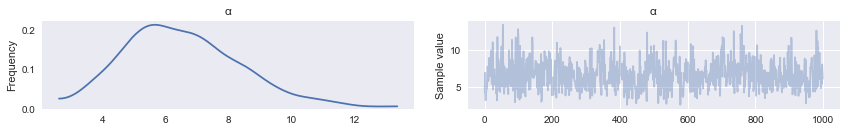

In [23]:
traceplot(trace[-nkeep:], varnames=['α'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x23dd42be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c3a21c88>]], dtype=object)

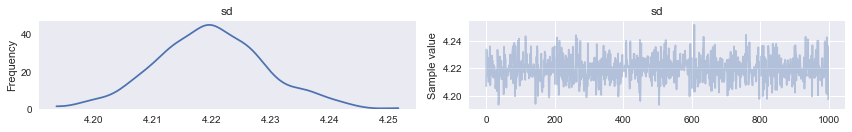

In [24]:
traceplot(trace[-nkeep:], varnames=['sd'])

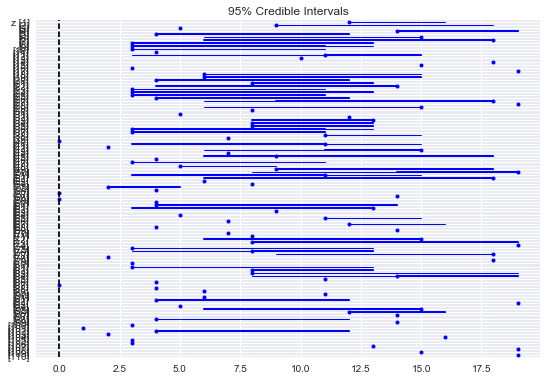

In [25]:
forestplot(trace[-nkeep:], varnames=['z'])

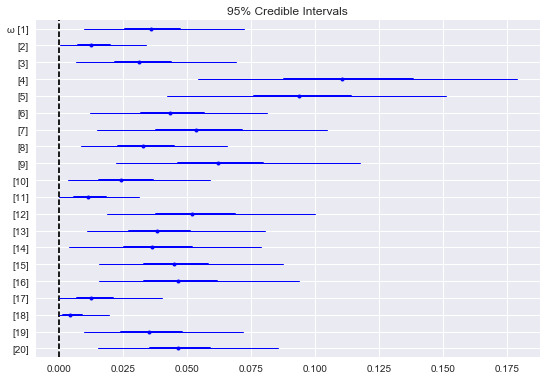

In [26]:
forestplot(trace[-nkeep:], varnames=['ω'])

In [27]:
top_groups = trace['ω', -nkeep:].mean(0).argsort()[::-1]

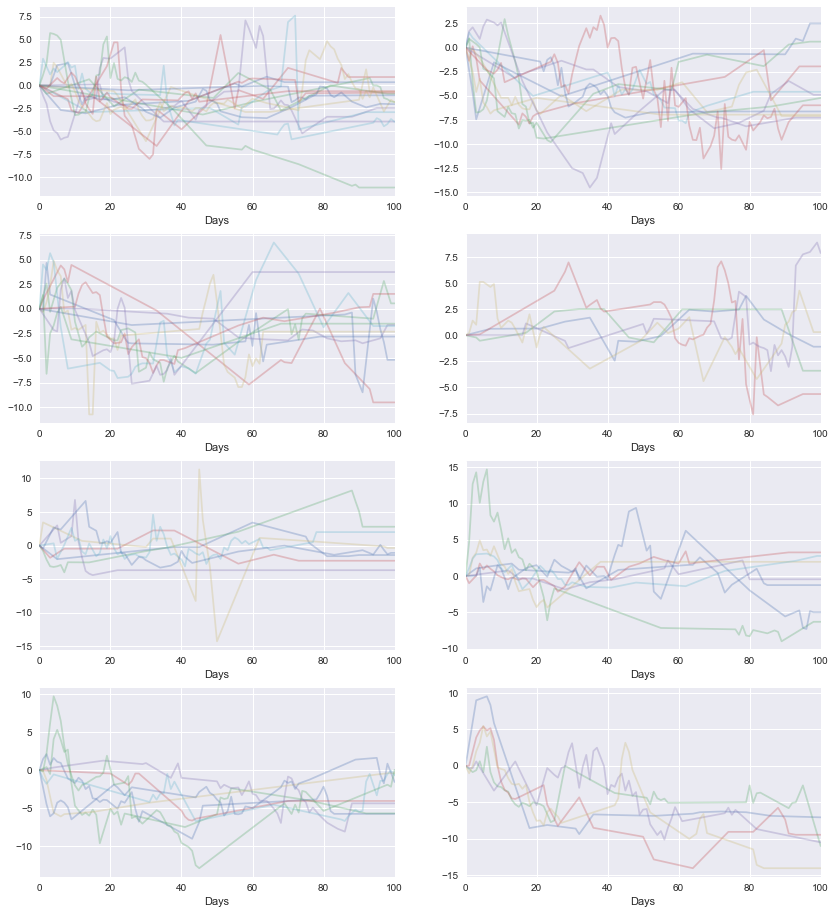

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(14,16))
for i,ax in enumerate(axes.ravel()):
    (data_subset.iloc[:, np.median(trace['z'], 0)==top_groups[i]].interpolate(limit=100)
                .plot(legend=False, alpha=0.3, ax=ax))
    #axes.set_ylabel('Weight (kg)');

Look at time series broken into 1-year series

In [92]:
weights_by_patient = pd.read_csv('../data/clean/weights_by_patient.csv', index_col=0)
weights_by_patient.shape

(5372, 638)

In [112]:
data_chunks = []

days, patients = weights_by_patient.shape

interval = 180

i = 0
while (interval*(i+1))<days:
    
    data_subset = weights_by_patient.loc[interval*i:interval*(i+1)]
    data_subset = data_subset.loc[:, data_subset.notnull().sum() >= 10]
    data_chunks.append(data_subset.reset_index(drop=True))
    i += 1

In [113]:
subseries_data = pd.concat(data_chunks, axis=1, ignore_index=True)

In [114]:
change_by_patient = subseries_data.apply(lambda s: s - s.loc[~s.isnull()].iloc[0], axis=0)

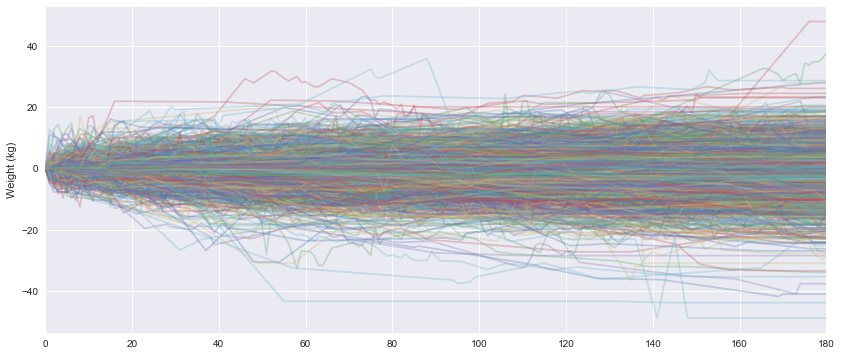

In [115]:
fig, axes = plt.subplots(figsize=(14,6))
(change_by_patient.interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

In [119]:
K = 30
D, N = data_subset.shape

In [120]:
nknots = 10
knots = np.linspace(0, interval, nknots)

In [121]:
with Model() as model_subseries:
    
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=K)
    ω = Deterministic('ω', stick_breaking(β))
    
    z = Categorical('z', ω, shape=N)
    
    σ = HalfCauchy('σ', 5, shape=K)

    θ = tt.stack([GaussianRandomWalk('θ_%i' % i, sd=σ[i], shape=nknots) for i in range(K)])

    sd = HalfCauchy('sd', 5)
    
    for i in range(N):
        
        data = change_by_patient.iloc[:, i]
        observed = ~np.isnan(data)
        y = data[observed]
        x = np.where(observed)[0].reshape(-1,1)
        n = y.shape[0]
        
        Normal('trajectory_%i' % i, interpolate(knots, θ[z[i]], x), sd=sd, observed=y)




In [122]:
niterations = 4000
nkeep = 1000

In [123]:
with model_subseries:
    trace = sample(niterations, init=None, tune=niterations-nkeep, random_seed=20090425)

Assigned NUTS to α_log_
Assigned NUTS to β_logodds_
Assigned CategoricalGibbsMetropolis to z
Assigned NUTS to σ_log_
Assigned NUTS to θ_0
Assigned NUTS to θ_1
Assigned NUTS to θ_2
Assigned NUTS to θ_3
Assigned NUTS to θ_4
Assigned NUTS to θ_5
Assigned NUTS to θ_6
Assigned NUTS to θ_7
Assigned NUTS to θ_8
Assigned NUTS to θ_9
Assigned NUTS to θ_10
Assigned NUTS to θ_11
Assigned NUTS to θ_12
Assigned NUTS to θ_13
Assigned NUTS to θ_14
Assigned NUTS to θ_15
Assigned NUTS to θ_16
Assigned NUTS to θ_17
Assigned NUTS to θ_18
Assigned NUTS to θ_19
Assigned NUTS to θ_20
Assigned NUTS to θ_21
Assigned NUTS to θ_22
Assigned NUTS to θ_23
Assigned NUTS to θ_24
Assigned NUTS to θ_25
Assigned NUTS to θ_26
Assigned NUTS to θ_27
Assigned NUTS to θ_28
Assigned NUTS to θ_29
Assigned NUTS to sd_log_
INFO (theano.gof.compilelock): Waiting for existing lock by process '21532' (I am process '18151')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/fonnescj/.theano/compiledir_Darwin

KeyboardInterrupt: 